In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine 
from scipy.misc import imread, imresize, imsave  # for plots 
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook
color = sns.color_palette()

In [2]:
def preprocess():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    #df_train.drop(['id', 'store_and_fwd_flag'], axis = 1, inplace = True)
    #df_test.drop(['id', 'store_and_fwd_flag'], axis = 1, inplace = True)
    df_train[['pickup_datetime', 'dropoff_datetime']] = df_train[['pickup_datetime', 'dropoff_datetime']].apply(pd.to_datetime, errors='coerce')
    df_test[['pickup_datetime']] = df_test[['pickup_datetime']].apply(pd.to_datetime, errors='coerce')
    
    return df_train, df_test


In [3]:
train_df, test_df = preprocess()

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


There were no null instances in train data! Our journey seemed to be happy :) <br/>

From now on, we are going to see the distribution of Y variables what we predict. And then we have a time to consider what we should draw during EDA.

C:\Users\samsung\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



Time taken by above cell is -0.690460205078125


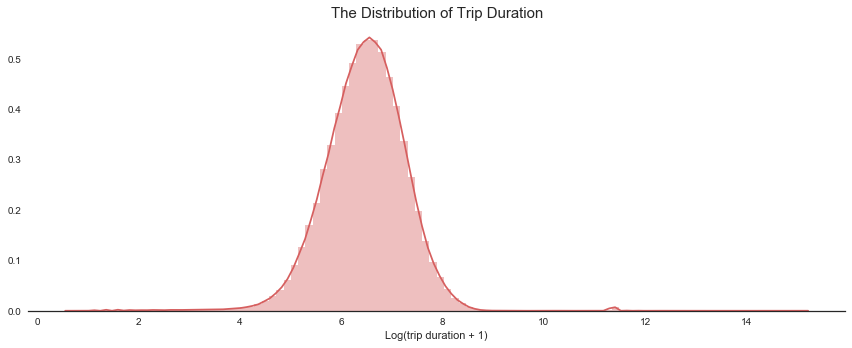

In [5]:
start = time.time()
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1, figsize = (12, 5), sharex = True)
sns.despine(left = True)
sns.distplot(np.log1p(train_df["trip_duration"].values), axlabel = "Log(trip duration + 1)", label = "Trip Duration", bins = 100, color = "r")
#plt.setp(axes, yticks = [])
plt.title("The Distribution of Trip Duration", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(start - end))
plt.show()

In [6]:
import scipy.stats as stats
stats.normaltest(np.log1p(train_df["trip_duration"].values))

NormaltestResult(statistic=148792.90978954008, pvalue=0.0)

It looked like to a normal distribution, but the distribution was never normal if the pvalue is near 0 according to normaltest by stats. However what we seized from the distribution, the data was spreaded out from the mean value.
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
* https://stackoverflow.com/questions/12838993/scipy-normaltest-how-is-it-used

## Time to let we know what we draw

I am interested in time traveling regard of pickup_hour, day_of_week, day_of_month, month(which almost looked like similar with day_of_year, I guess). <br />
And I thought that simply showing categorical values or continuous values with a time flow, but what if the dataframe was grouped by catgorical, then showing cat / con values with the time flow seemed to be nicer and friendly let us know the meaning of the dataframe. <br />
<br/>

#### categorical - vendor_id, pos 
What kind of categorical values was in the data?  <br />
    1. On the surface, the variable 'vendor_id' means where each instance comes from.
    2. On the surface, there is the variable 'id'. However it didn't have a direct meaning to which we interpret, but just assisted us to count the number of instances in a group. 
    3. On the inside of data, we should see the area of NYC, such as Mahatten and Brooklyn. 
\* In my opinion, the variable 'store and fwd flag' was meaningless. Here is the explanation in the Kaggle data description. <br />
&nbsp;&nbsp;&nbsp;&nbsp;store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending <br />
&nbsp;&nbsp;&nbsp;&nbsp;to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip <br />
&nbsp;&nbsp;&nbsp;&nbsp;It just said the system of each taxi is new or old! I guessed that the variable 'vendor id' influenced to 'store and fwd flag'. <br />

#### continous - passenger_count, trip_duration 
What kind of continuous values was in the data? <br />
    1. passenger_count 
    2. trip_duration
I will keep tracking whether further continous variables exists or not. <br/>

### Our process of the EDA
    Preprocess
    1. Divde the Area of NYC with a positional data by K Means
    2. Get the time data by pd.to_datetime().dt.xxx
    
    Draw graph
    1. Draw Univariate Graph
    2. Draw multivariate graph and the time series graph!

##### 1. Now time for to divde the area of NYC!

Before going the trip, we saw the distribution of longtitude and latitude to exclude outliers from our data. And then we used K-means with <br/> scikit learn into longtitude and latitude data. From those datas, we indirectly extracted the neighbors of NYC. 

C:\Users\samsung\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



Time taken by above cell is 2.0793864727020264


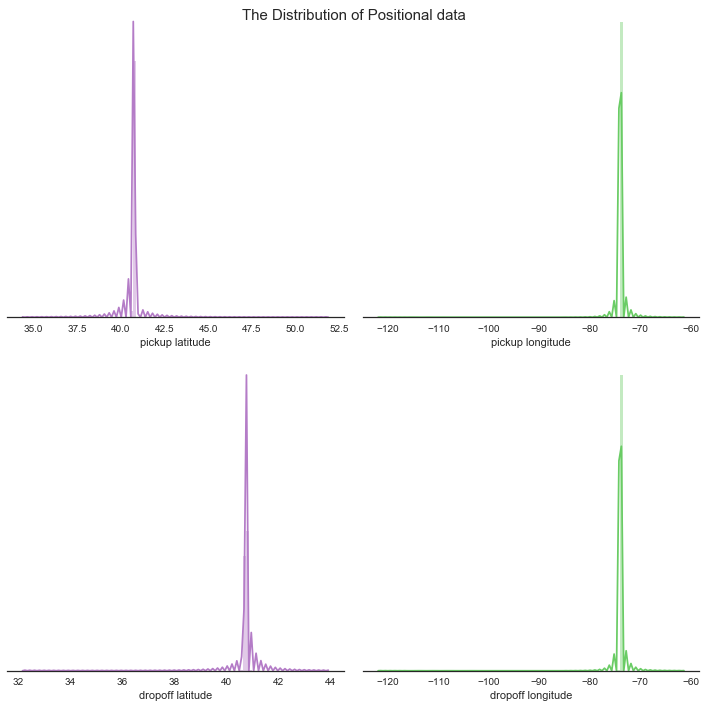

In [8]:
start = time.time()
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(2,2, figsize = (10,10), sharex = False, sharey = False)
sns.despine(left = True)
sns.distplot(train_df["pickup_latitude"].values, axlabel = "pickup latitude", color = "m", bins = 100, ax = axes[0,0])
sns.distplot(train_df["pickup_longitude"].values, axlabel = "pickup longitude", color = "g", bins = 100, ax = axes[0,1])
sns.distplot(train_df["dropoff_latitude"].values, axlabel = "dropoff latitude", color = "m", bins = 100, ax = axes[1,0])
sns.distplot(train_df["dropoff_longitude"].values, axlabel = "dropoff longitude", color = "g", bins = 100, ax = axes[1,1])
plt.setp(axes, yticks = [])
plt.suptitle("The Distribution of Positional data", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end-start))
plt.show()

Wow those data sooooooooo dense on the little interval than the entire one. We have to kick out of the outliers from each variables.How we do it?  <br/>
    1. With percentile
    2. NYC offical position with map
We used percentile :)

In [4]:
train_ny = train_df.copy()

In [5]:
start = time.time()
alpha = 0.3
pick_max_lat = np.percentile(train_df['pickup_latitude'].values, 99) + alpha
pick_min_lat = np.percentile(train_df['pickup_latitude'].values, 1) - alpha
pick_max_long = np.percentile(train_df['pickup_longitude'].values, 99) + alpha
pick_min_long = np.percentile(train_df['pickup_longitude'].values, 1) - alpha

drop_max_lat = np.percentile(train_df['dropoff_latitude'].values, 99) + alpha
drop_min_lat = np.percentile(train_df['dropoff_latitude'].values, 1) - alpha
drop_max_long = np.percentile(train_df['dropoff_longitude'].values, 99) + alpha
drop_min_long = np.percentile(train_df['dropoff_longitude'].values, 1) - alpha

train_ny = train_ny.loc[(pick_min_lat < train_df['pickup_latitude']) & (train_df['pickup_latitude'] < pick_max_lat)]
train_ny = train_ny.loc[(pick_min_long < train_df['pickup_longitude']) & (train_df['pickup_longitude'] < pick_max_long)]
train_ny = train_ny.loc[(drop_min_lat < train_df['dropoff_latitude']) & (train_df['dropoff_latitude'] < drop_max_lat)]
train_ny = train_ny.loc[(drop_min_long < train_df['dropoff_longitude']) & (train_df['dropoff_longitude'] < drop_max_long)]

end = time.time()
print("Time taken by above cell is {}".format(end-start))

Time taken by above cell is 1.4589729309082031


C:\Users\samsung\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



Time taken by above cell is 2.36958384513855


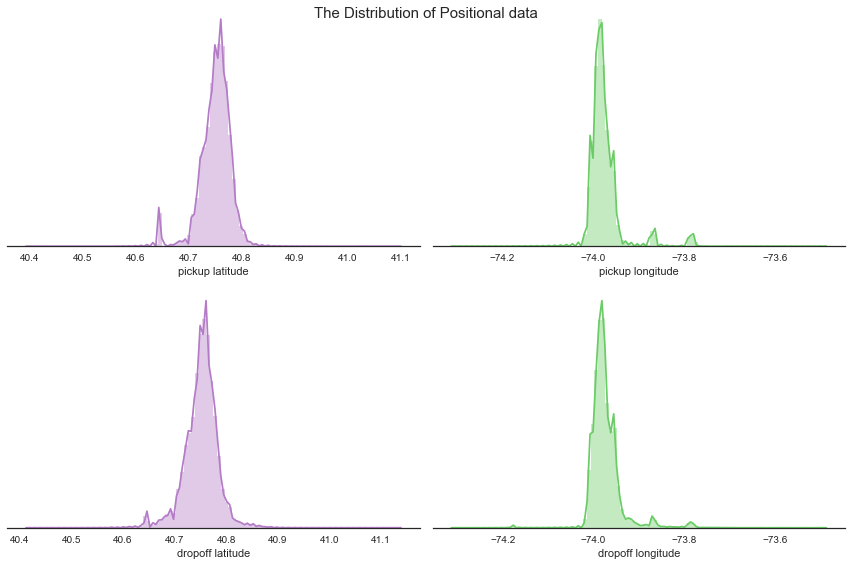

In [12]:
start = time.time()
sns.set(style = "white", palette = "muted", color_codes = True)
fig, axes = plt.subplots(2,2, figsize = (12, 8), sharex = False, sharey = False)
sns.despine(left = True)
sns.distplot(train_ny["pickup_latitude"].values, axlabel = "pickup latitude", color = "m", bins = 100, ax = axes[0,0])
sns.distplot(train_ny["pickup_longitude"].values, axlabel = "pickup longitude", color = "g", bins = 100, ax = axes[0,1])
sns.distplot(train_ny["dropoff_latitude"].values, axlabel = "dropoff latitude", color = "m", bins = 100, ax = axes[1,0])
sns.distplot(train_ny["dropoff_longitude"].values, axlabel = "dropoff longitude", color = "g", bins = 100, ax = axes[1,1])
plt.setp(axes, yticks = [])
plt.suptitle("The Distribution of Positional data", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end-start))
plt.show()

This is more rational :)

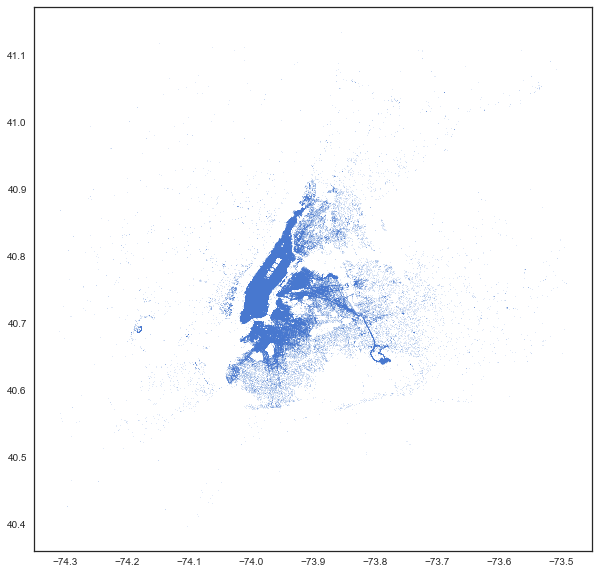

In [28]:
longitude = list(train_ny.pickup_longitude) + list(train_ny.dropoff_longitude)
latitude = list(train_ny.pickup_latitude) + list(train_ny.dropoff_latitude)
plt.figure(figsize = (10, 10))
plt.plot(longitude, latitude, '.', alpha = 0.4, markersize = 1)
plt.show()

It's was worse than what I have seen in Kaggle notebook. So I changed into a Kaggle notebook version.

C:\Users\samsung\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



Time taken by above cell is 4.83322548866272
1452385 1452385


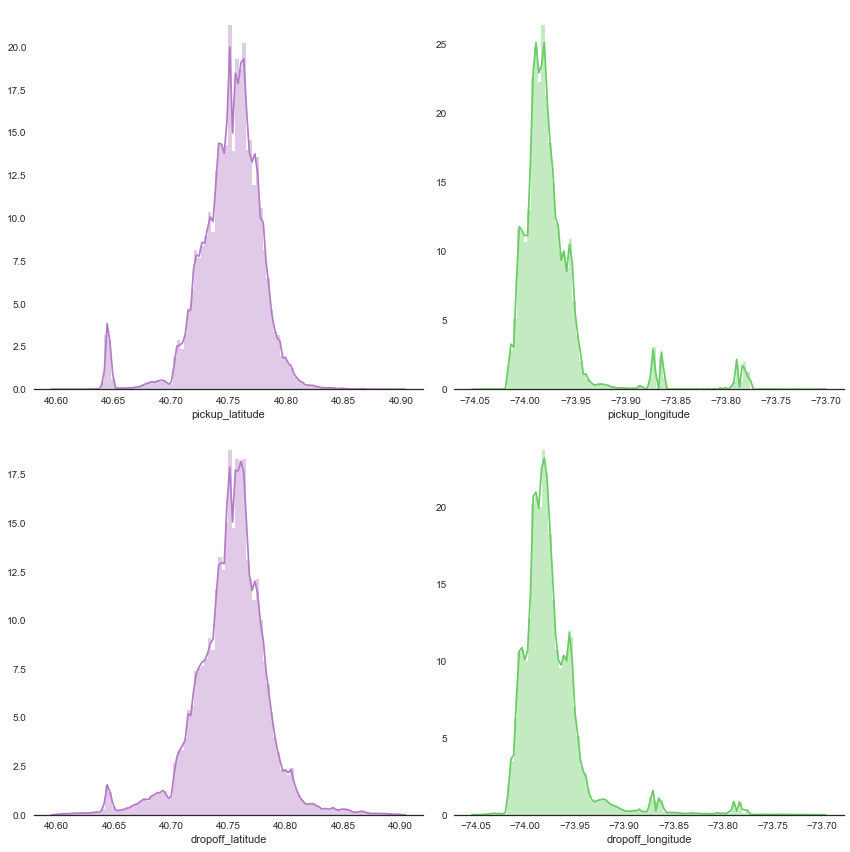

In [6]:
start = time.time()
train_ny = train_df.loc[(train_df.pickup_latitude > 40.6) & (train_df.pickup_latitude < 40.9)]
train_ny = train_ny.loc[(train_ny.dropoff_latitude>40.6) & (train_ny.dropoff_latitude < 40.9)]
train_ny = train_ny.loc[(train_ny.dropoff_longitude > -74.05) & (train_ny.dropoff_longitude < -73.7)]
train_ny = train_ny.loc[(train_ny.pickup_longitude > -74.05) & (train_ny.pickup_longitude < -73.7)]
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(2,2, figsize = (12, 12), sharex = False, sharey = False)
sns.despine(left = True)
sns.distplot(train_ny['pickup_latitude'].values, axlabel = 'pickup_latitude', color = "m", bins = 100, ax = axes[0,0])
sns.distplot(train_ny['pickup_longitude'].values, axlabel = 'pickup_longitude', color = "g", bins = 100, ax = axes[0,1])
sns.distplot(train_ny['dropoff_latitude'].values, axlabel = 'dropoff_latitude', color = "m", bins = 100, ax = axes[1,0])
sns.distplot(train_ny['dropoff_longitude'].values, axlabel = 'dropoff_longitude', color = "g", bins = 100, ax = axes[1,1])
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end-start))
print(train_ny.shape[0], train_ny.shape[0])
plt.show()

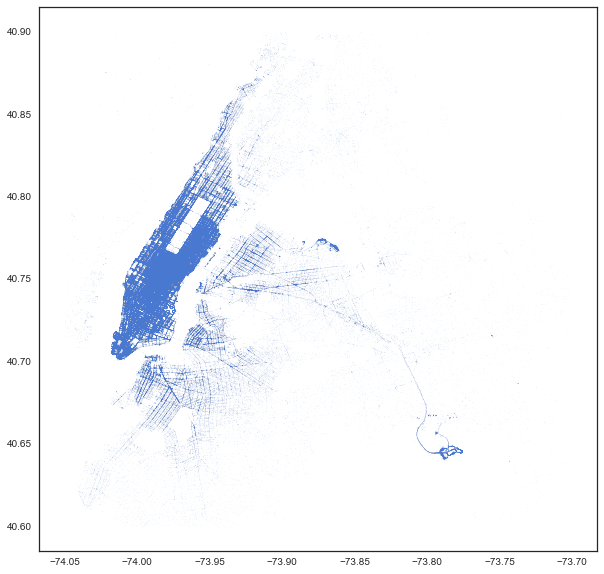

In [8]:
longitude = list(train_ny.pickup_longitude) + list(train_ny.dropoff_longitude)
latitude = list(train_ny.pickup_latitude) + list(train_ny.dropoff_latitude)
plt.figure(figsize = (10, 10))
plt.plot(longitude, latitude, '.', alpha = 0.4, markersize = 0.4)
plt.show()

In [11]:
train_ny[['pickup_datetime', 'dropoff_datetime']].to_csv('train_time.csv', index = False)

In [9]:
start = time.time()
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude


kmeans = KMeans(n_clusters = 15, random_state = 2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize = (10, 10))
for itr, label in enumerate(loc_df.label.unique()):
    label_index = loc_df[loc_df.label == label].index
    plt.plot(loc_df['longitude'].loc[label_index], loc_df['latitude'].loc[label_index],
            '.', alpha = 0.3, markersize = 0.3)
plt.title('Clusters of New York', fontsize = 15)
end = time.time()
print("Time taken by above cell is {}".format(end-start))
plt.show()




KeyboardInterrupt: 

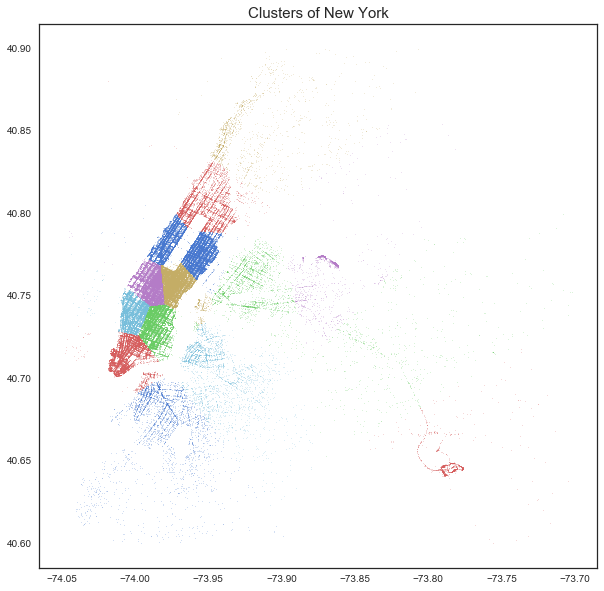

In [47]:
plt.figure(figsize = (10, 10))
for itr, label in enumerate(loc_df.label.unique()):
    label_index = loc_df[loc_df.label == label].index
    plt.plot(loc_df['longitude'].loc[label_index], loc_df['latitude'].loc[label_index],
            '.', alpha = 0.3, markersize = 2)
plt.title('Clusters of New York', fontsize = 15)
plt.show()

In [48]:
train_ny['pickup_pos'] = kmeans.predict(train_ny[['pickup_longitude','pickup_latitude']].values)
train_ny['dropoff_pos'] = kmeans.predict(train_ny[['dropoff_longitude','dropoff_latitude']].values)

In [49]:
train_ny.sample(3)

id  vendor_id     pickup_datetime    dropoff_datetime  \
996956   id3068660          2 2016-06-08 07:43:47 2016-06-08 07:52:32   
646408   id3826987          1 2016-03-28 10:13:42 2016-03-28 10:19:18   
1381006  id2101995          2 2016-03-29 17:36:52 2016-03-29 17:48:13   

         passenger_count  pickup_longitude  pickup_latitude  \
996956                 1        -73.958412        40.778519   
646408                 2        -73.952576        40.791485   
1381006                1        -73.993027        40.757610   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
996956          -73.947304         40.795181                  N   
646408          -73.955109         40.787365                  N   
1381006         -74.000214         40.728931                  N   

         trip_duration  pickup_pos  dropoff_pos  
996956             525           1            5  
646408             336           5            1  
1381006            681           4            9

In [7]:
def dividing_df(train_ny):
    """
    This function is for our multivariate graph.
    """
    start = time.time()
    train_time = pd.DataFrame(train_ny[['pickup_datetime', 'dropoff_datetime']].copy())
    train_time.loc[:, 'month'] = train_time['pickup_datetime'].dt.month
    train_time.loc[:, 'pickup_hour'] = train_time['pickup_datetime'].dt.hour
    train_time.loc[:, 'week_of_year'] = train_time['pickup_datetime'].dt.weekofyear
    train_time.loc[:, 'day_of_year'] = train_time['pickup_datetime'].dt.dayofyear
    train_time.loc[:, 'day_of_week'] = train_time['pickup_datetime'].dt.dayofweek
    cat_var = ['id', 'passenger_count', 'store_and_fwd_flag', 'trip_duration']
    con_var = ['vendor_id', 'pickup_pos', 'dropoff_pos'] # + the area in New York City
    train_con = train_ny[con_var]
    train_cat = train_ny[cat_var]
    end = time.time()
    print("Time taken by above cell : {}".format(end - start))


    train_con.to_csv('train_con.csv', index = False)
    train_cat.to_csv('train_cat.csv', index = False)
    train_time.to_csv('train_time.csv', index = False)

train_con = pd.read_csv('train_con.csv')
train_cat = pd.read_csv('train_cat.csv')
train_time = pd.read_csv('train_time.csv')

In [11]:
train_time['pickup_datetime'] = pd.to_datetime(train_time['pickup_datetime'])
train_time.loc[:, 'month'] = train_time['pickup_datetime'].dt.month
train_time.loc[:, 'pickup_hour'] = train_time['pickup_datetime'].dt.hour
train_time.loc[:,'day'] = train_time['pickup_datetime'].dt.day
train_time.loc[:, 'week_of_year'] = train_time['pickup_datetime'].dt.weekofyear
train_time.loc[:, 'day_of_year'] = train_time['pickup_datetime'].dt.dayofyear
train_time.loc[:, 'day_of_week'] = train_time['pickup_datetime'].dt.dayofweek

Preparing data is finished let go to univariate and multivariate with time 

### 1. Univariate
        1. categorical, vendor_id, pickup/dropoff_pos
        2. continuous, passenger_count, trip_duration
        3. time, month, pickup_hour, week_of_year, day_of_year, day_of_week.

        1. Categorical, vendor_id, pickup/dropoff_pos

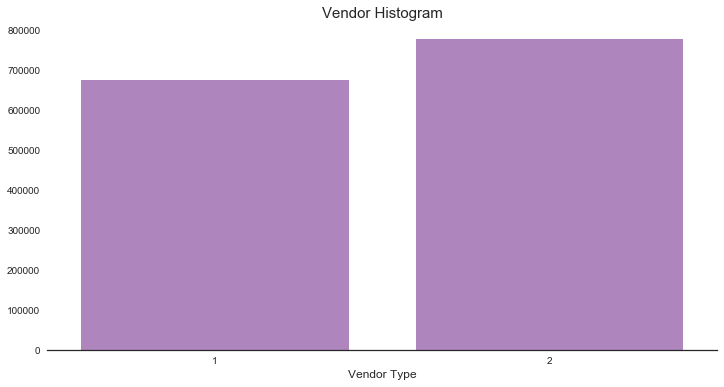

In [57]:
cnt_tmp = train_con['vendor_id'].value_counts()
sns.set(style = "white", palette = "muted", color_codes = True)
f, ax = plt.subplots(1,1, figsize = (12,6))
sns.despine(left = True)
sns.barplot(cnt_tmp.index, cnt_tmp.values, color = "m")
plt.xlabel("Vendor Type", fontsize = 12)
plt.title("Vendor Histogram", fontsize = 15)
plt.show()

Each size of vendor was not severly different.

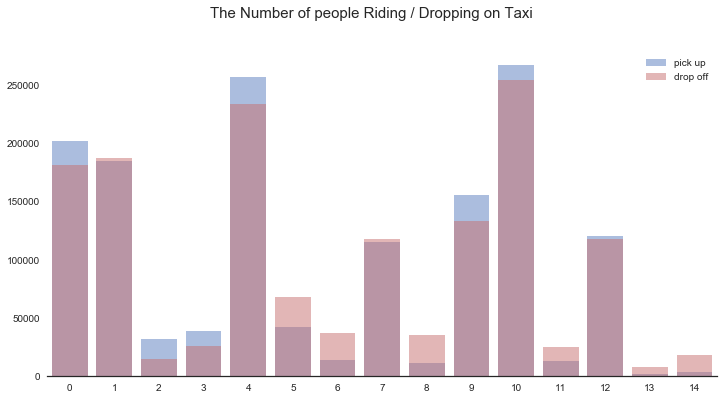

In [68]:
cnt_tmp = train_con['pickup_pos'].value_counts()
cnt_tmp2 = train_con['dropoff_pos'].value_counts()
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1, figsize = (12,6))
sns.despine(left = True)
sns.barplot(cnt_tmp.index, cnt_tmp.values, color = "b", label = "pick up", alpha = 0.5, ax = axes)
sns.barplot(cnt_tmp2.index, cnt_tmp2.values, color = "r", label = "drop off", alpha = 0.5,  ax = axes)
plt.legend()
plt.suptitle("The Number of people Riding / Dropping on Taxi", fontsize = 15)
plt.show()

Area 2,3 : People usually were riding. The meaning is when they came back, they perhaps used different traffic type. <br/>
Area 5,6,8,11,13, 14 : People generally got out of taxi in these area. Some of them maybe were waypoint or nightlife town on surburb of NYC.

        2. continous, passenger_count, trip_duration

            Trip_duration is same with what we have seen first. So skip.

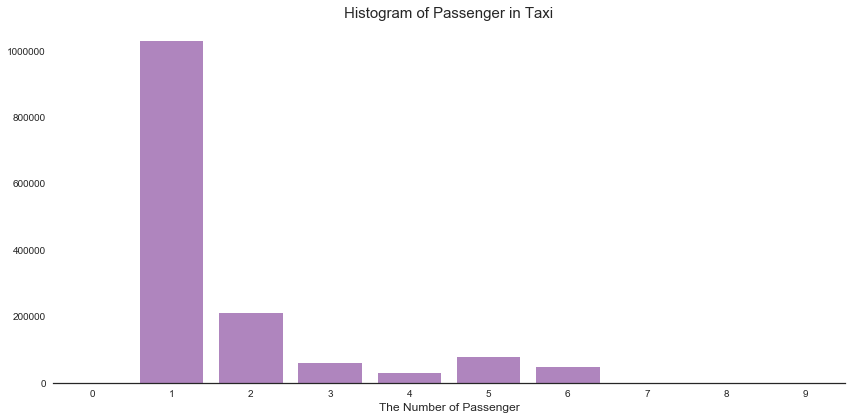

In [81]:
cnt_tmp = train_cat['passenger_count'].value_counts()
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (12,6))
sns.despine(left = True)
sns.barplot(cnt_tmp.index, cnt_tmp.values, color = "m")
plt.xlabel("The Number of Passenger", fontsize = 12)
plt.title("Histogram of Passenger in Taxi", fontsize = 15)
plt.tight_layout()
plt.show()

...0???

In [78]:
[(cnt_tmp == x).sum() for x in [0, 7, 8, 9]]

[0, 0, 0, 0]

Okay Okay, It's impossible. People in NY usually took a taxi alone.

        3. Time, month, pickup_hour, week_of_year, day_of_year, day_of_week.

In [85]:
print(len(train_time.columns))

6


### Now Have a time to evaluate sns.tsplot, sns.barplot, and bokeh line. <br/>
    [Result]
    * Using bokeh if you want to dramatically see the difference and decrease time to draw 
    * Using sns.tsplot if you want to dramatically see the difference 
    * Using sns.barplot, if you want to prove that the data doesn't have a severe difference.
    
    - In time effectiveness, bokeh line > sns.barplot > sns.tsplot
    - In dramatic effectiveness, bokeh line == sns.tsplot > sns.barplot
    
    

#### The Quantity of Taxi in Month

Time taken by above cell is 0.14909982681274414


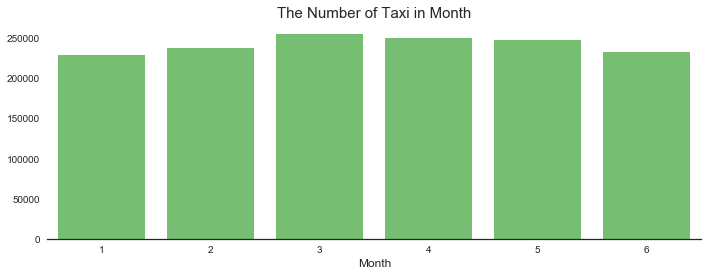

In [139]:
start = time.time()
cnt_tmp = train_time['month'].value_counts()
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (10,4))
sns.despine(left = True)
sns.barplot(cnt_tmp.index, cnt_tmp.values, color = "g")
plt.xlabel("Month", fontsize = 12)
plt.title("The Number of Taxi in Month", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end - start))
plt.show()

Time taken by above cell is 0.35823869705200195


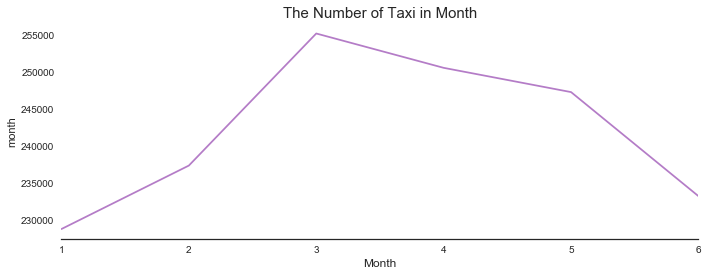

In [135]:
start = time.time()
cnt_tmp = train_time['month'].value_counts()
cnt_tmp = cnt_tmp.reset_index()
cnt_tmp['unit'] = 1
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (10,4))
sns.despine(left = True)
sns.tsplot(cnt_tmp, time = "index", value = "month", unit = "unit", color = "m")
plt.xlabel("Month", fontsize = 12)
plt.title("The Number of Taxi in Month", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end - start))
plt.show()

#### The Quantity of Taxi in Hour

Time taken by above cell is 0.3022005558013916


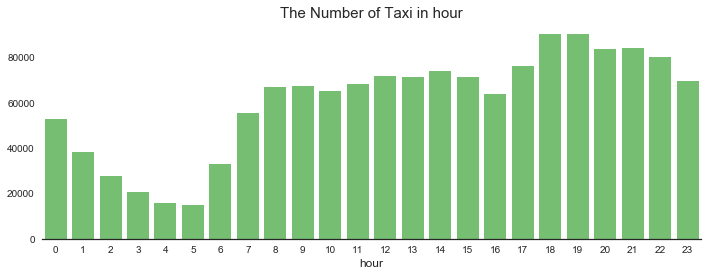

In [140]:
start = time.time()
cnt_tmp = train_time['pickup_hour'].value_counts()
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (10,4))
sns.despine(left = True)
sns.barplot(cnt_tmp.index, cnt_tmp.values, color = "g")
plt.xlabel("hour", fontsize = 12)
plt.title("The Number of Taxi in hour", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end - start))
plt.show()

Time taken by above cell is 0.604400634765625


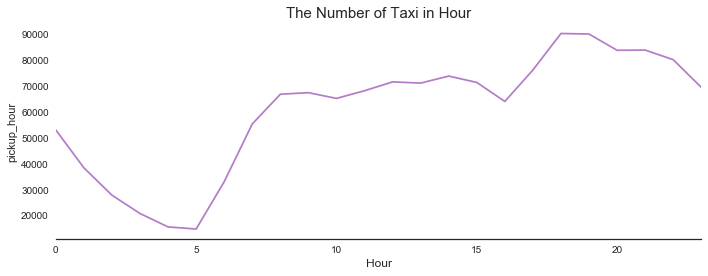

In [151]:
start = time.time()
cnt_tmp = train_time['pickup_hour'].value_counts()
cnt_tmp = cnt_tmp.reset_index()
cnt_tmp['unit'] = 1
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (10,4))
sns.despine(left = True)
sns.tsplot(cnt_tmp, time = 'index', value = 'pickup_hour', unit = 'unit', color = "m")
plt.xlabel("Hour", fontsize = 12)
plt.title("The Number of Taxi in Hour", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end - start))
plt.show()

In [12]:
start = time.time()
output_notebook()
start = time.time()
cnt_tmp = train_time['pickup_hour'].value_counts()
cnt_tmp = cnt_tmp.reset_index()
cnt_tmp.sort_values('index', inplace = True)
p = figure(plot_width = 800, plot_height = 250)
p.title.text = "The Number of Taxi in Pickup Hour"
p.line(cnt_tmp['index'], cnt_tmp['pickup_hour'], line_width = 2, color = Spectral4[0], alpha = 0.8)
end = time.time()
print("Time taken by above cell is {}".format(end-start))
show(p)

Loading BokehJS ...

Time taken by above cell is 0.05203437805175781


### The Quantity of Taxi in day_of_week

Time taken by above cell is 0.5993978977203369


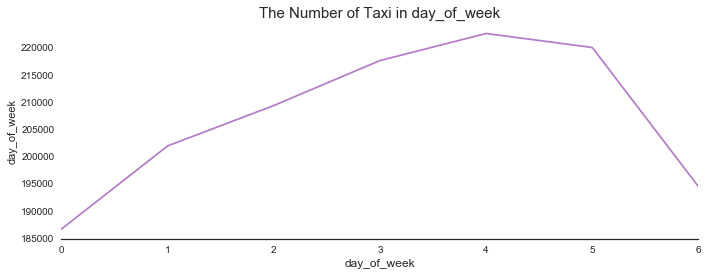

In [154]:
start = time.time()
cnt_tmp = train_time['day_of_week'].value_counts()
cnt_tmp = cnt_tmp.reset_index()
cnt_tmp['unit'] = 1
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (10,4))
sns.despine(left = True)
sns.tsplot(cnt_tmp, time = 'index', value = 'day_of_week', unit = 'unit', color = "m")
plt.xlabel("day_of_week", fontsize = 12)
plt.title("The Number of Taxi in day_of_week", fontsize = 15)
plt.tight_layout()
end = time.time()
print("Time taken by above cell is {}".format(end-start))
plt.show()

In [13]:
start = time.time()
output_notebook()
start = time.time()
cnt_tmp = train_time['day_of_week'].value_counts()
cnt_tmp = cnt_tmp.reset_index()
cnt_tmp.sort_values('index', inplace = True)
p = figure(plot_width = 800, plot_height = 250)
p.title.text = "The Number of Taxi in Day of Week"
p.line(cnt_tmp['index'], cnt_tmp['day_of_week'], line_width = 2, color = Spectral4[0], alpha = 0.8)
end = time.time()
print("Time taken by above cell is {}".format(end-start))
show(p)

Loading BokehJS ...

Time taken by above cell is 0.04803204536437988


### The Quantity of taxi in day_of_week

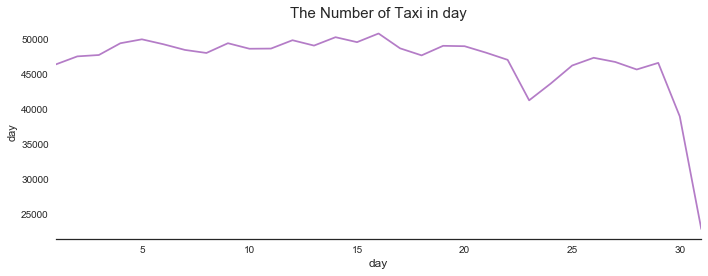

In [134]:
cnt_tmp = train_time['day'].value_counts()
cnt_tmp = cnt_tmp.reset_index()
cnt_tmp['unit'] = 1
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (10,4))
sns.despine(left = True)
sns.tsplot(cnt_tmp, time = 'index', value = 'day', unit = 'unit', color = "m")
plt.xlabel('day', fontsize = 12)
plt.title("The Number of Taxi in day", fontsize = 15)
plt.tight_layout()
plt.show()

### The Quantity of taxi in week_of_year

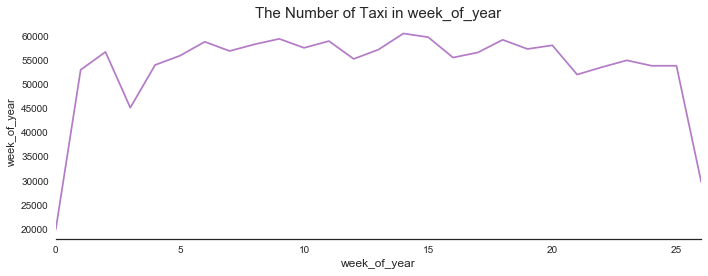

In [128]:
cnt_tmp = train_time['week_of_year'].value_counts()
cnt_tmp = cnt_tmp.reset_index()
cnt_tmp['unit'] = 1
cnt_tmp['index'].loc[cnt_tmp['index'] == 53] = 0
sns.set(style = "white", palette = "muted", color_codes = True)
f, axes = plt.subplots(1,1,figsize = (10,4))
sns.despine(left = True)
sns.tsplot(cnt_tmp, time = 'index', value = 'week_of_year', unit = 'unit', color = "m")
plt.xlabel("week_of_year", fontsize = 12)
plt.title("The Number of Taxi in week_of_year", fontsize = 15)
plt.tight_layout()
plt.show()

---
The following is just a practice of Kaggle notebook
___

In [142]:
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
#from bokeh.sampledata.stocks import AAPL, IBM, MSFT, GOOG

In [ ]:
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
#from bokeh.sampledata.stocks import AAPL, IBM, MSFT, GOOG
output_notebook()


p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")
p.title.text = 'Click on legend entries to hide the corresponding lines'

for data, name, color in zip([ts_v1, ts_v2], ["vendor 1", "vendor 2"], Spectral4):
    #df = pd.DataFrame(data)
    #df['date'] = pd.to_datetime(df['date'])
    tmp = data
    p.line(tmp['pickup_date'], tmp['trip_duration'], line_width=2, color=color, alpha=0.8, legend=name)
    
p.legend.location = "top_left"
p.legend.click_policy="hide"
show(p)
end = time.time()
print(end - start)

In [9]:
start = time.time()
df.loc[:, 'pickup_date'] = df['pickup_datetime'].dt.date

ts_v1 = pd.DataFrame(df.loc[df.vendor_id == 1].groupby('pickup_date')['trip_duration'].mean())
ts_v2 = pd.DataFrame(df.loc[df.vendor_id == 2].groupby('pickup_date')['trip_duration'].mean())


ts_v1.reset_index(inplace = True)
ts_v2.reset_index(inplace = True)

from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
#from bokeh.sampledata.stocks import AAPL, IBM, MSFT, GOOG
output_notebook()


p = figure(plot_width=800, plot_height=250, x_axis_type="datetime")
p.title.text = 'Click on legend entries to hide the corresponding lines'

for data, name, color in zip([ts_v1, ts_v2], ["vendor 1", "vendor 2"], Spectral4):
    #df = pd.DataFrame(data)
    #df['date'] = pd.to_datetime(df['date'])
    tmp = data
    p.line(tmp['pickup_date'], tmp['trip_duration'], line_width=2, color=color, alpha=0.8, legend=name)
    
p.legend.location = "top_left"
p.legend.click_policy="hide"
show(p)
end = time.time()
print(end - start)

Loading BokehJS ...

9.903606414794922


Over 1 Transaction 137029
1 Transaction 75427
Time taken by above cell is 10.233824491500854


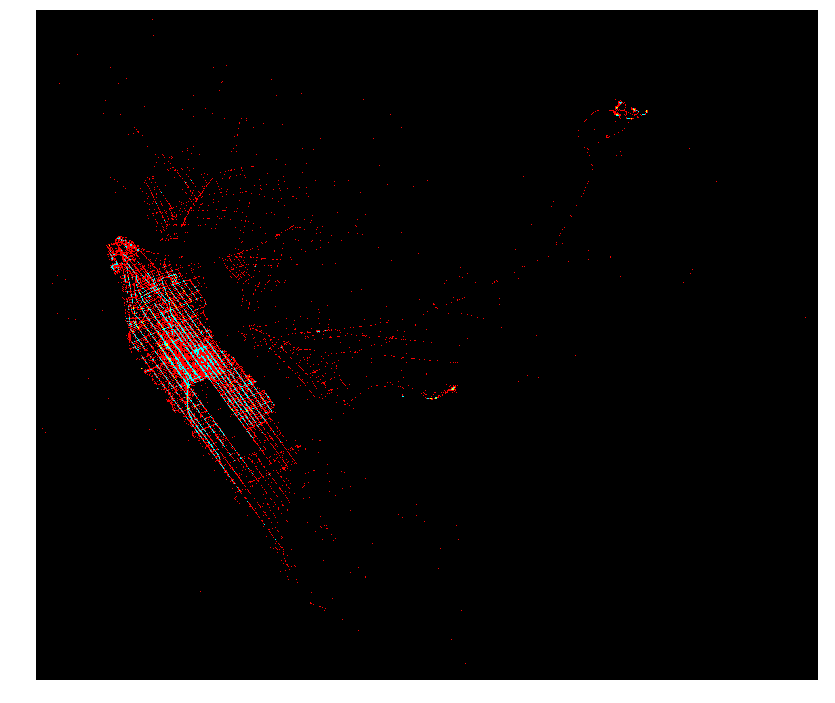

In [44]:
start = time.time()
rgb = np.zeros((3000, 3500,3), dtype = np.uint8)
rgb[...,0] = 0
rgb[...,1] = 0
rgb[...,2] = 0
df['pick_lat_new'] = list(map(int, (df['pickup_latitude'] - (40.6000))*10000))
df['drop_lat_new'] = list(map(int, (df['dropoff_latitude'] - (40.6000))*10000))
df['pick_lon_new'] = list(map(int, (df['pickup_longitude'] - (-74.050))*10000))
df['drop_lon_new'] = list(map(int,(df['dropoff_longitude'] - (-74.050))*10000))

summary_plot = pd.DataFrame(df.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())
summary_plot.reset_index(inplace = True)
print("Over 1 Transaction {}".format(sum(summary_plot.id != 1)))
print("1 Transaction {}".format(sum(summary_plot.id == 1)))
lat_list = summary_plot['pick_lat_new'].unique()
for itr, lat in enumerate(lat_list):
    lon_list = summary_plot.loc[summary_plot.pick_lat_new == lat]["pick_lon_new"].tolist()
    unit = summary_plot.loc[summary_plot.pick_lat_new == lat]["id"].tolist()
    for itr2, lon in enumerate(lon_list):
        val = unit[lon_list.index(lon)]
        if (val // 50) > 0:
            rgb[lat, lon, 0] = 255
            rgb[lat, lon, 1] = 255
            rgb[lat, lon, 2] = 0
        elif (val // 10) > 0:
            rgb[lat, lon, 0] = 0
            rgb[lat, lon, 1] = 255
            rgb[lat, lon, 2] = 255
        else:
            rgb[lat, lon, 0] = 255
            rgb[lat, lon, 1] = 0
            rgb[lat, lon, 2] = 0
fig, ax = plt.subplots(1,1, figsize = (14, 20))
end = time.time()
print("Time taken by above cell is {}".format(end-start))
ax.imshow(rgb, cmap = "hot")
ax.set_axis_off()
plt.show()

In [46]:
start = time.time()
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

import math
def bearing_array(lat1, lng1, lat2, lng2):
    """ function was taken from beluga's notebook as this function works on array
    while my function used to work on individual elements and was noticably slow"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

end = time.time()
print("Time taken by above cell is {}.".format((end-start)))

Time taken by above cell is 0.0.


In [52]:
start = time.time()
train_data = df.copy()
train_data["pickup_datetime"] = pd.to_datetime(train_data["pickup_datetime"])
train_data.loc[:, "pick_month"] = train_data["pickup_datetime"].dt.month
train_data.loc[:, "hour"] = train_data["pickup_datetime"].dt.hour
train_data.loc[:, "weaek_of_year"] = train_data["pickup_datetime"].dt.weekofyear
train_data.loc[:, "day_of_year"] = train_data["pickup_datetime"].dt.dayofyear
train_data.loc[:, "day_of_week"] = train_data["pickup_datetime"].dt.dayofweek
end = time.time()

print("Time taken by above cell is {}.".format(end-start))

Time taken by above cell is 1.754173755645752.


In [53]:
start = time.time()
#train_data = train_df

train_data.loc[:,'hvsine_pick_drop'] = haversine_(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'bearing'] = bearing_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
train_data.head()

Time taken by above cell is 1.193795919418335.


id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag     ...      pick_lon_new  \
0         40.765602                  N     ...               678   
1         40.731152                  N     ...               695   
2         40.710087                  N     ...               709   
3         40.706718                  N     ...               399   
4         40.782520                  N     ...               769   

   drop_lon_new  pick_month  hour  weaek_of_year  day_of_year  day_of_week  \
0           853           3    17             11           74            0   
1           505           6     0             23          164            6   
2           446           1    11              3           19            1   
3           377           4    19             14           97            2   
4           770           3    13             12           86            5   

   hvsine_pick_drop  manhtn_pick_drop     bearing  
0          1.498521          1.735433   99.970196  
1          1.805507          2.430506 -117.153768  
2          6.385098          8.203575 -159.680165  
3          1.485498          1.661331 -172.737700  
4          1.188588          1.199457  179.473585  

[5 rows x 23 columns]

0.5193479061126709


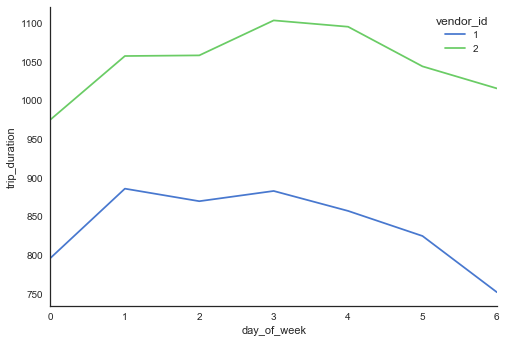

In [59]:
start = time.time()
summary_wdays_avg_duration = pd.DataFrame(train_data.groupby(['vendor_id', 'day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit'] = 1
sns.set(style = "white", palette = "muted", color_codes = True)
sns.tsplot(data = summary_wdays_avg_duration, time = "day_of_week", unit = "unit", condition = "vendor_id", value = "trip_duration")
sns.despine(bottom = False)
end = time.time()
print(end - start)
plt.show()


1452385


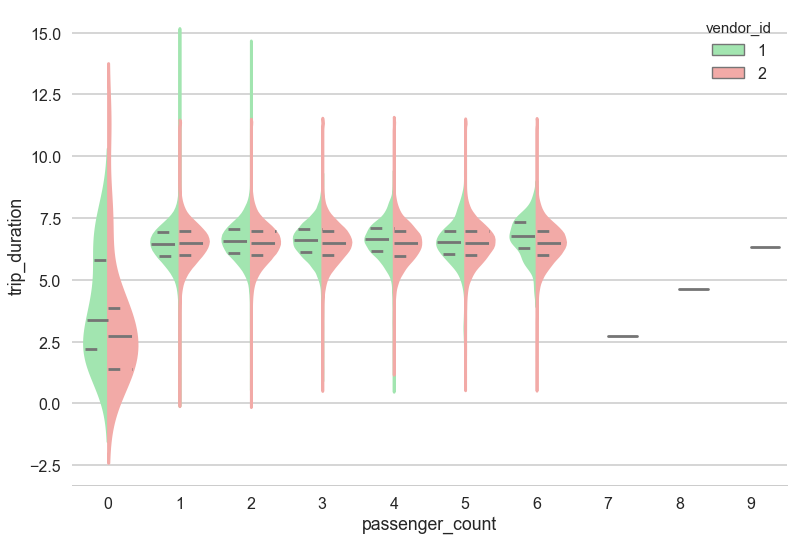

In [62]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set_context("poster")
train_data2 = train_data.copy()
train_data2['trip_duration']= np.log(train_data['trip_duration'])
sns.violinplot(x="passenger_count", y="trip_duration", hue="vendor_id", data=train_data2, split=True,
               inner="quart",palette={1: "g", 2: "r"})

sns.despine(left=True)
print(df.shape[0])
plt.show()